## This notebook demonstrates how to prepare a video dataset with tensorflow.

### The dataset used for this demo is the `UCF101` human action dataset.

In [1]:
!pip install remotezip
!pip install git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.10.0-py3-none-any.whl size=7063 sha256=fbedb58d13e7466663e006611d48b2fc9defb2b36e6c2b0bad01e8c84522de4c
  Stored in directory: /root/.cache/pip/wheels/96/8e/56/88bae637c3c0e96b9d892b93b099ebf08efd17016e63eb7459
Successfully built remotezip
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dirvw1bu
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-dirvw1bu
  Resolved https://github.com/tensorflow/docs to commit 085f6863002da862ffe2cc9b442e20a6bf40ac2c
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184397 sha256=19b1771d11ced0e94bdffc2bf7e0be6aa620ee5119ae2f3d4a92d7c9b22d1504
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5hk1blk/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import os
import cv2
import tqdm
import random
import pathlib
import itertools
import collections
import numpy as np
import remotezip as rz

import tensorflow as tf

#Modules to display an animation using imageio
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Download a subset of the `UCF101` dataset.

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [4]:
## Create a function that uses the remotezip library to examine contents of the zip in the URL.

def list_files_from_zip_url(zip_url):
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

In [5]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

### Define the `get_class` function that retrieves the class name from a filname.

### Then create a function called `get_files_per_class` which converts the list of all files into a dictionary listing the files for each class.

In [6]:
def get_class(fname):
    '''Retrieve the name of the class given a filename.
    
    Args:
        fname: Name of the file in the UCF101 dataset.
    Returns:
        Class that the file belongs to.
    '''
    return fname.split("_")[-3]

In [7]:
def get_files_per_class(files):
    '''Retrieves the files that belongs to each class.
    
    Args:
        files: List of files in the dataset.
    Returns:
        Dictionary of class names (key) and files (values).
    '''
    
    files_for_class = collections.defaultdict(list)
    
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
        
    return files_for_class

### Choose how many classes you would like to use and how many videos you would like per class.

In [8]:
NUM_CLASSES = 10
FILES_PER_CLASS = 10

In [9]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print(f'Number of classes: {len(classes)}')
print(f'Number of videos for class[0]: {len(files_for_class[classes[0]])}')

Number of classes: 101
Number of videos for class[0]: 145


### Create a function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class.

In [10]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
    '''Creates a dictionary with the class name and a subset of the files in that class.
     Args:
         files_for_class: Dictionary of classs names (key) and files (values).
         classes: List of classes.
         files_per_class: Number of files per class of interest.
         
    Returns:
        Dictionary with class as key and list of specified number of video files in that class.
        '''
    files_subset = {}
    for class_name in classes:
        class_files = files_for_class[class_name]
        files_subset[class_name] = class_files[:files_per_class]
        
    return files_subset

In [11]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], 
                                       FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

### Define helper functions that splits videos into training, validation and test splits.

### The videos are downloaded from a URL with the zip file and placed intot their respective subdirectories.

In [12]:
def download_from_zip(zip_url, to_dir, file_names):
    '''Download contents of the zip file from the zip URL.
    
    Args:
        zip_url : A URL with a zip file.
        to_dir: A directory to download data to.
        file_names: Name of files to download.
    '''
    
    with rz.RemoteZip(zip_url) as zip:
        for fn in tqdm.tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn
            
            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(output_file)

In [13]:
def split_class_lists(files_for_class, count):
    '''Returns the list of files belonging to a subset of dta as well as the remainder of files that need to be downloaded.
    
    Args:
        files_for_class; Files belonging to a particular class of data.
        count: Number of files to download.
        
    Returns:
        Files belonging to the subset of data and dictionary of the reminder of files that need to be downloaded.
        '''
    split_files = []
    remainder = {}
    
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][:count]
    
    return split_files, remainder

#### The following `download_ufc_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The splits argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [14]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
    '''Download a subset of the UCF101 dataset and split them into train, validation and test splits.
    Args:
    zip_url: A URL with  a zip file with the data.
    num_classes: Number of labels.
    splits: Dictionary specifying the training, validation and test splits.
    download_dir: Directory to download data to.
    '''
    files = list_files_from_zip_url(zip_url)
    for f in files:
        path = os.path.normpath(f)
        tokens = path.split(os.sep)
        if len(tokens) <= 2:
            files.remove(f) #Remove that item from the list if it does not have a filename.
            
    files_for_class = get_files_per_class(files)
    
    classes = list(files_for_class.keys())[:num_classes]
    
    for cls in classes:
        random.shuffle(files_for_class[cls])
        
    #Only use the number of classes you want in the dictionary.
    files_for_class = {x: files_for_class[x] for x in classes}
    
    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ':')
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        dirs[split_name] = split_dir
        
    return dirs

In [15]:
download_dir = pathlib.Path('./UCF101_subset/')

subset_paths = download_ucf_101_subset(URL,
                                      num_classes = NUM_CLASSES, 
                                      splits = {'train': 30, 'val': 10, 'test': 10},
                                      download_dir=download_dir)

train :


100%|██████████| 300/300 [01:53<00:00,  2.63it/s]


val :


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


test :


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


In [16]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))

video_total = video_count_train + video_count_val + video_count_test

print(f'Total videos: {video_total}')

Total videos: 500


## Create frames from each video file.
***

#### The `frames_from_video_file` function splits the videos into frames, reads a randomly chosen span of `n_frames` out of a video file and returns them as a numpy array. 

#### To reduce memory and computation overhead, choose a small number of frames. In addition, pick the same number of frames for each video, which makes it easier to work on batches of data.

In [17]:
def format_frames(frame, output_size):
    '''Pad and resize an image from a video.
    
    Args:
        frame: Image that needs to be resized and padded.
        output_size: Pixel size of frame image output.
        
    Return:
        Formatted frame with padding of specified output size.
        '''
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    
    return frame

In [18]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
    '''Creates frames from each video file present for each category.
    
    Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image
    Return: 
        A numpy array of frames in the shape of (n_frames, height, width, channels)
        '''
    #Read each video by frame.
    result = []
    src = cv2.VideoCapture(str(video_path))
    
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step
    
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)
    
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))
    
    for _ in range(n_frames - 1):
        if ret:
            frame = tf.image.convert_image_dtype(frame, tf.float32)
            frame = tf.image.resize_with_pad(frame, *output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
            
    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    
    return result

## Visualize video data.

#### The `frames_from_video_file` function that returns a set of frames as a numpy array.

In [19]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  19.4M      0  0:00:02  0:00:02 --:--:-- 19.4M


In [20]:
video_path = 'End_of_a_jam.ogv'

sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

2022-10-30 19:14:15.556611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:14:15.680752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:14:15.681559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:14:15.685139: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(10, 224, 224, 3)

In [21]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps = 10)
    
    return embed.embed_file('./animation.gif')


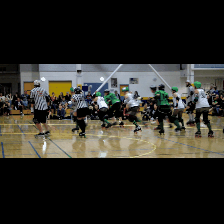

In [22]:
to_gif(sample_video)


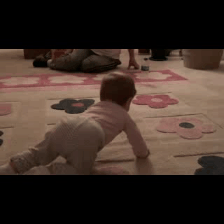

In [23]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

#### Define the `FrameGenerator` class in order to create an iterable object that can feed data into the TensorFlow data pipeline. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [24]:
class FrameGenerator:
    def __init__(self, path, n_frames):
        '''Returns a set of frames with their associated label.
        
        Args:
            path: Video file paths.
            classes: List of labels for classification.
        '''
        self.path = path
        self.n_frames = n_frames
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))
        
    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes
    
    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        
        pairs = list(zip(video_paths, classes))
        random.shuffle(pairs)
        
        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name] #Encode labels.
            yield video_frames, label
            

In [25]:
#Test the FrameGenerator object.
fg = FrameGenerator(subset_paths['train'], 10)

frames, label = next(fg())

print(f'Shape: {frames.shape}')
print(f'Label: {label}')

Shape: (10, 224, 224, 3)
Label: 0


#### Finally, create a TensorFloe data input pipeline. This pipeline that you create from the generator object allows you to feed in data to a model. In this video pipeline, each element is a single set of frames and its associated label.

In [26]:
#Create the training set.
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                   tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10),
                                         output_signature = output_signature)

train_ds.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int16, name=None))

In [27]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

val_ds.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int16, name=None))

In [28]:
#Print the shapes of the data.
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


2022-10-30 19:15:03.050776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Configure the dataset for performance.

#### Use buffered prefetching such that you yield data from the disk without having I/O become blocking. Two important functions to use while loading data are:
- `Dataset.cache`: Keeps the set of frames in memory after they are loaded off the disk during the first epoch. This function ensures that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performat on-disk cache.

- `Dataset.prefetch`: Overlaps data preprocessng and model execution while training. 

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

## To prepare the data to be fed into the model, use batching as shown below.

#### These dimensions are `[batch_size, number_of_frames, height, width, channels]`

In [30]:
train_ds = train_ds.batch(30)
val_ds = val_ds.batch(30)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_frames.shape}')

2022-10-30 19:15:37.726319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 239 of 1000
2022-10-30 19:15:40.218290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Shape of training set of frames: (30, 10, 224, 224, 3)
Shape of training labels: (30,)
Shape of validation set of frames: (30, 10, 224, 224, 3)
Shape of validation labels: (30, 10, 224, 224, 3)


## Next steps.

### Now that you have created a TensorFlow Dataset of video frames with their labels, you can use it with a deep learning model. The following classification model that uses a pre-trained `EfficientNet` trains to high accuracy in a few minutes:

In [32]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam', 
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
             metrics = ['accuracy'])


In [33]:
model.fit(train_ds, epochs = 5, 
         validation_data = val_ds, 
         callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/5


2022-10-30 19:16:39.807839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 23s 899ms/step - loss: 2.3198 - accuracy: 0.0933 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 2/5
10/10 [==============================] - 6s 588ms/step - loss: 2.3136 - accuracy: 0.0767 - val_loss: 2.3040 - val_accuracy: 0.1000
Epoch 3/5
10/10 [==============================] - 6s 591ms/step - loss: 2.3074 - accuracy: 0.1033 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 4/5
10/10 [==============================] - 6s 587ms/step - loss: 2.3092 - accuracy: 0.0700 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 5/5
10/10 [==============================] - 6s 588ms/step - loss: 2.3070 - accuracy: 0.0800 - val_loss: 2.3031 - val_accuracy: 0.1000
